#  Cheapest day before a flight to buy tickets prediction - Iteration 0

In [1]:
import sklearn
import pandas as pd
import seaborn
import glob


# 📦 Data provisioning
The flights is gathered from **google flights**, using a *webscraper*. It includes data from the routes **SOF-EIN** and **EIN-SOF**. The dataset includes data from **02.2025 - 12.2025**

In [2]:
data1 = pd.read_csv('./datasets/iteration0/flight_prices_SOF_EIN.csv', parse_dates=["departureDate"])
data2 = pd.read_csv('./datasets/iteration0/flight_prices_EIN_SOF.csv', parse_dates=["departureDate"])

main_data = pd.concat([data1, data2])

# 📃 Sample the data


In [3]:
main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday
4508,89,2025-05-22,70,Sofia,Eindhoven,False,False
9806,185,2025-08-17,226,Sofia,Eindhoven,False,True
9681,186,2025-08-15,211,Sofia,Eindhoven,False,True
4894,131,2025-05-23,90,Eindhoven,Sofia,False,False
1121,62,2025-03-24,28,Sofia,Eindhoven,False,False
8423,204,2025-07-26,121,Sofia,Eindhoven,False,True
1681,62,2025-04-04,29,Sofia,Eindhoven,False,False
256,55,2025-03-06,46,Sofia,Eindhoven,False,False
4056,107,2025-05-15,63,Sofia,Eindhoven,False,False
2084,89,2025-04-07,66,Eindhoven,Sofia,False,False


In [4]:
group_info = main_data.groupby(["departure_airport"])["departure_airport"].count()
group_info

departure_airport
Eindhoven    16958
Sofia        16288
Name: departure_airport, dtype: int64

# 🛠️ Preprocessing 

The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the days before a flight, containing the cheapest tickets. 

## 🎯 Target Variable


First, as the algorhitm is categorical, we need to convert the target variable into a category.

In [5]:
category_order = ['days < 7', '7 <= days < 14', '13 <= days < 30', '30 <= days < 60', '60 <= days < 100', ' 100 <= days >= 200', 'days > 200']

def categorize_daysAgo(days): # from 0 to 300
    if days < 7:
        return category_order[0]
    elif 7 <= days < 14:
        return category_order[1]
    elif 14 <= days < 30:
        return category_order[2]
    elif 30 <= days < 60:
        return category_order[3]
    elif 60 <= days < 100:
        return category_order[4]
    elif 100 <= days < 200:
        return category_order[5]
    else:
        return category_order[6]

main_data["daysAgo_category"] = main_data["daysAgo"].apply(categorize_daysAgo)
main_data['daysAgo_category'] = pd.Categorical(main_data['daysAgo_category'], categories=category_order, ordered=True)



Then, we need to convert the respectable non numerical values (airports and holidays) into numberical values

In [6]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
main_data["daysAgo_category_id"] = encoder.fit_transform(main_data["daysAgo_category"])

main_data["departure_airport_id"] = encoder.fit_transform(main_data["departure_airport"])
main_data["arrival_airport_id"] = encoder.fit_transform(main_data["arrival_airport"])

main_data["is_public_holiday"] = main_data["is_public_holiday"].astype(int)
main_data["is_school_holiday"] = main_data["is_school_holiday"].astype(int)

main_data.drop(["departure_airport", "arrival_airport"], axis=1, inplace=True)

main_data.sample(10)


,daysAgo,departureDate,price,is_public_holiday,is_school_holiday,daysAgo_category,daysAgo_category_id,departure_airport_id,arrival_airport_id
2327,98,2025-04-15,52,0,0,60 <= days < 100,3,1,0
1199,47,2025-03-26,38,0,0,30 <= days < 60,2,1,0
11973,244,2025-09-16,58,0,0,days > 200,6,0,1
6141,130,2025-06-18,58,0,0,100 <= days >= 200,0,1,0
8159,158,2025-07-21,89,0,1,100 <= days >= 200,0,1,0
8566,185,2025-07-28,121,0,1,100 <= days >= 200,0,1,0
11915,247,2025-09-22,74,1,0,days > 200,6,1,0
875,59,2025-03-19,26,0,0,30 <= days < 60,2,1,0
1607,70,2025-03-30,48,0,0,60 <= days < 100,3,0,1
4780,121,2025-05-21,51,0,0,100 <= days >= 200,0,0,1


In [7]:
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import parallel_coordinates

Now we will create several graphs to visualize relationships between the values of the dataset

/var/folders/y7/db2_95bs6k9djjfg92g5zmnr0000gn/T/ipykernel_61690/2544680406.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_range = main_data.groupby('daysAgo_category')['price'].mean().reset_index()


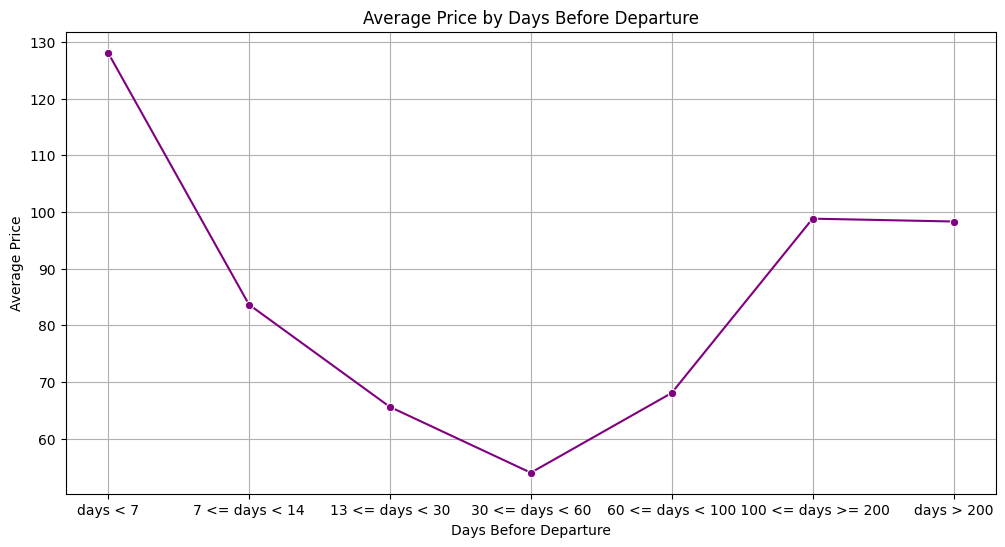

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

avg_price_by_range = main_data.groupby('daysAgo_category')['price'].mean().reset_index()

# Sort the DataFrame by 'daysAgo_category' to ensure the plot uses the correct order
avg_price_by_range = avg_price_by_range.sort_values('daysAgo_category', ascending=True)

# Plotting average price by days range
plt.figure(figsize=(12,6))
sns.lineplot(x='daysAgo_category', y='price', data=avg_price_by_range, marker='o', color='purple')

# Adding labels and title
plt.title('Average Price by Days Before Departure')
plt.xlabel('Days Before Departure')
plt.ylabel('Average Price')

# Add grid to the plot
plt.grid(True)

# Show plot
plt.show()

The graph clearly shows that the **best time to buy** a ticket is **between 30 and 60 days before departure**, with prices peaking when tickets are booked much earlier or very close to the departure date.

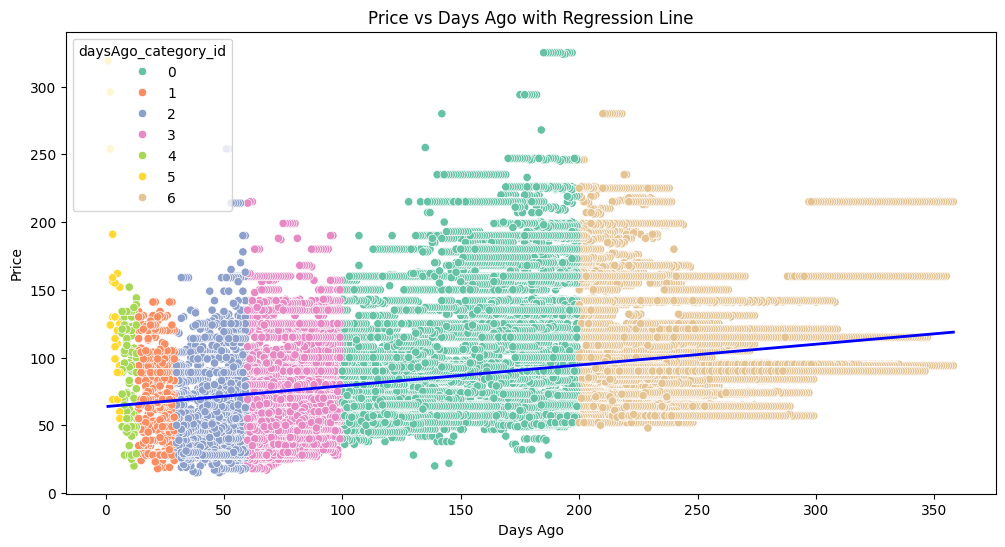

In [9]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='daysAgo', y='price', data=main_data, hue='daysAgo_category_id', palette='Set2')
sns.regplot(x='daysAgo', y='price', data=main_data, scatter=False, color='blue', line_kws={'linewidth': 2})
plt.title('Price vs Days Ago with Regression Line')
plt.xlabel('Days Ago')
plt.ylabel('Price')
plt.show()

This graph indicates that the number of days before departure (daysAgo) has a positive correlation with price, meaning that as flights are booked earlier, their prices tend to rise. This could be due to factors like demand for early bookings or promotions on last-minute deals. However, there is still a significant amount of variation in the price for each category, suggesting that other factors (like seasonality, holidays, etc.) could also be influencing ticket prices.

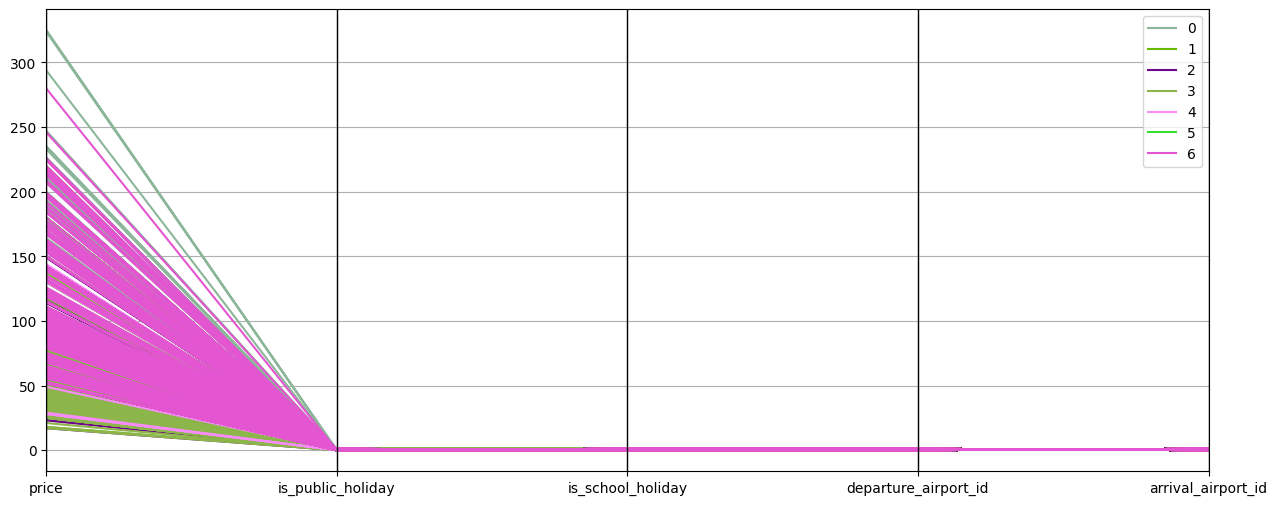

In [10]:
# Define numeric columns
numeric_candidates = ['price', 'is_public_holiday', 'is_school_holiday', 'departure_airport_id', 'arrival_airport_id', 'daysAgo_category_id']

# Plot the parallel coordinates with the encoded values
fig = plt.figure(figsize=[15,6])

ax = parallel_coordinates(main_data[numeric_candidates].sample(5000).sort_values(by="daysAgo_category_id"), 
                          class_column='daysAgo_category_id')

plt.show()

From the parallel coordinates plot, here are the key observations we can conclude:
- Price variation is significant across the ``daysAgo_category_id`` categories, with some categories showing higher prices, especially as the number of days before departure increases.
- Features like *holidays* a d *airports*, and seem to have minimal effect on price in this case, and the main factor influencing price appears to be the number of days before departure (captured by ``daysAgo_category_id``).

### 💡 Feature Selection


To optimize our model, we must select only those features that best explain the variance in the target variable—the number of days before departure when the ticket is cheapest. Since flight prices fluctuate due to multiple factors, we will focus on features that exhibit distinguishable patterns across different days. Our dataset includes variables such as ``` departureDate, daysAgo, departure_airport, arrival_airport, and holiday indicators (is_public_holiday, is_school_holiday).```

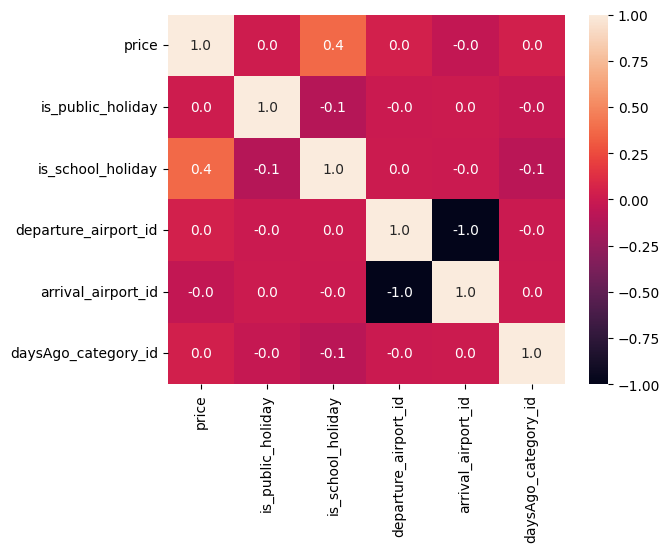

In [11]:
correlations = main_data[numeric_candidates].corr()
plot = seaborn.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

Conclusion:
- **Strong Factors**: ``is_school_holiday`` moderately influences price, while other features like `departure_airport_id` and `arrival_airport_id` seem to have little or no impact.
- **Weak/No Correlations**: Public holidays have *minimal impact* on ticket prices in this dataset, suggesting these features are *less important* for optimizing the model in terms of price prediction.

In [12]:
# Define the target and parameters
target = 'daysAgo_category_id'
params = ['price', 'is_public_holiday', 'is_school_holiday', 'departure_airport_id', 'arrival_airport_id', 'daysAgo']

X = main_data[params]
y = main_data[target]
# maybe try without public holidays

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")
X_train

There are in total 33246 observations, of which 26596 are now in the train set, and 6650 in the test set.


,price,is_public_holiday,is_school_holiday,departure_airport_id,arrival_airport_id,daysAgo
3399,60,0,1,0,1,76
7418,150,0,0,0,1,149
4896,90,0,0,0,1,129
16154,90,0,0,0,1,290
7728,56,0,1,1,0,155
...,...,...,...,...,...,...
8454,190,0,1,0,1,167
15027,90,0,0,0,1,294
5361,53,0,0,1,0,104
2495,63,0,0,1,0,54


# 🧬 Modelling

`k Nearest Neighbour` will be used at these first stages of the development

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the KNeighborsRegressor model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predict the target values on the test set
pred = knn.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. This shows for every one of the classes how well the model performed.

In [15]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.03037593984962406
Root Mean Squared Error (RMSE): 0.23282508197570226
R² Score: 0.9923828861258805


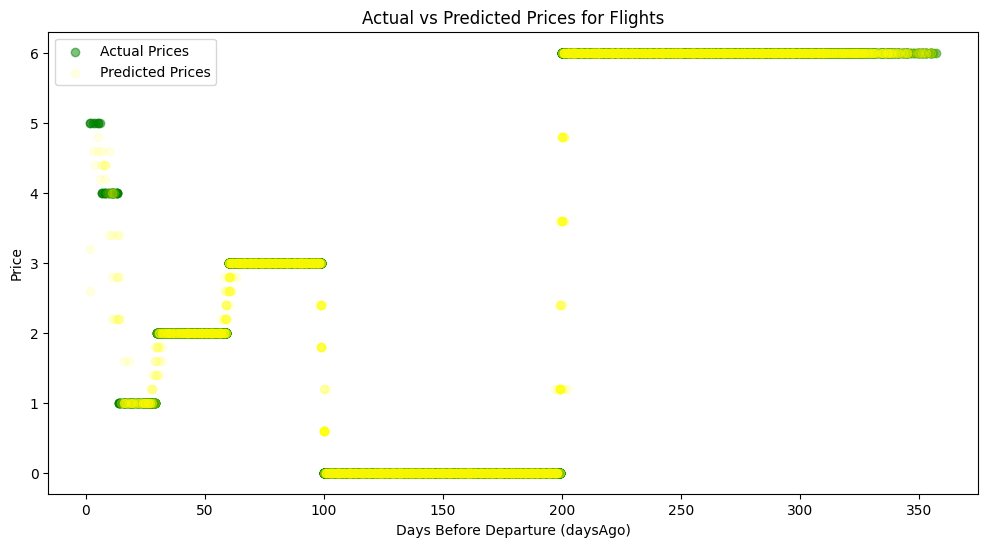

In [16]:
plt.figure(figsize=(12, 6))

# Scatter plot for actual prices
plt.scatter(X_test['daysAgo'], y_test, color='green', alpha=0.5, label='Actual Prices')

# Scatter plot for predicted prices
plt.scatter(X_test['daysAgo'], pred, color='yellow', alpha=0.1, label='Predicted Prices')

# Adding titles and labels
plt.title('Actual vs Predicted Prices for Flights')
plt.xlabel('Days Before Departure (daysAgo)')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()

Based on this chart, we can conclude that the model seems to correctly predict when the tickets will be the cheapest, but has difficulti when the actual value is close to the "edge" of the category and overlaps with another category.

---------------